In [ ]:
install.packages(c("keras","tfdatasets","Metrics"))

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘Rcpp’, ‘RcppTOML’, ‘here’, ‘png’, ‘config’, ‘tfautograph’, ‘reticulate’, ‘tensorflow’, ‘tfruns’, ‘zeallot’




In [ ]:
library(keras)
library(tfdatasets) # examples from tensor flow
library(tidyverse)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6      ✔ purrr   0.3.5 
✔ tibble  3.1.7      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.3      ✔ forcats 0.5.2 

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [ ]:
isolates <- read.csv('isolates_filtered_collect_date_imputed.csv')

############### Just keep some certain sources for now: ###############
# temp_source <- c('environmental swab', 'food', 'blood')
# temp_source <- c('pork', 'chicken', 'beef', 'blood','milk')
# temp_source <- c('food', 'blood') # this is used in neural network
# temp_source <- c('food', 'blood', 'water') # this is used in multinomial

# isolates_sub <- isolates %>% filter(Isolation.source %in% temp_source)


# keep complete cases for mindiff/same:
isolates_sub_comp <- isolates[complete.cases(isolates$Min.diff) & complete.cases(isolates$Min.same), ]


In [ ]:
# isolates_org <- read.csv('isolates_sub_comp.csv')
isolates_org <-isolates_sub_comp

In [ ]:
isolates <- isolates_org %>% filter(Isolation.source %in% c('blood', 'chicken'))
isolates <- isolates[,c('AMR.genotypes' , 'Min.diff', 'Min.same', 'Isolation.source')]
isolates$Isolation.source <- as.numeric(as.factor(isolates$Isolation.source)) 
isolates$AMR.genotypes <- as.factor(isolates$AMR.genotypes)
head(isolates)

,AMR.genotypes,Min.diff,Min.same,Isolation.source
,<fct>,<int>,<int>,<dbl>
1,"fosX=COMPLETE,lin=COMPLETE",16,22,1
2,"fosX=COMPLETE,lin=COMPLETE",17,6,1
3,"fosX=COMPLETE,lin=COMPLETE",11,12,1
4,"fosX=COMPLETE,lin=COMPLETE",25,22,2
5,"fosX=COMPLETE,lin=COMPLETE",4,8,1
6,"fosX=COMPLETE,lin=COMPLETE",19,1,1


In [ ]:
dim(isolates)

[1] 1408    4

In [ ]:
sum(complete.cases(isolates[,c('AMR.genotypes' , 'Min.diff', 'Min.same')]))

[1] 1408

In [ ]:
isolates_mat <- model.matrix(Isolation.source~AMR.genotypes + Min.diff + Min.same, isolates)

dim(isolates_mat)

[1] 1408   18

In [ ]:
head(isolates_mat)


,(Intercept),"AMR.genotypesabc-f=HMM,erm(C)=PARTIAL_END_OF_CONTIG,fosX=COMPLETE,lin=COMPLETE","AMR.genotypesabc-f=HMM,fosX=COMPLETE,lin=COMPLETE","AMR.genotypesabc-f=HMM,fosX=COMPLETE,lin=COMPLETE,tet(M)=COMPLETE","AMR.genotypesabc-f=HMM,fosX=COMPLETE,lin=COMPLETE,tet(O)=PARTIAL","AMR.genotypesabc-f=HMM,fosX=COMPLETE,lin=PARTIAL_END_OF_CONTIG","AMR.genotypesaph(4)-Ia=PARTIAL_END_OF_CONTIG,fosX=COMPLETE,lin=COMPLETE","AMR.genotypesblaTEM-116=COMPLETE,fosX=COMPLETE,lin=COMPLETE","AMR.genotypesdfrD=COMPLETE,fosX=COMPLETE,lin=COMPLETE","AMR.genotypesfexA=COMPLETE,fosX=COMPLETE,lin=COMPLETE","AMR.genotypesfosX=COMPLETE,lin=COMPLETE","AMR.genotypesfosX=COMPLETE,lin=COMPLETE,lin=PARTIAL","AMR.genotypesfosX=COMPLETE,lin=COMPLETE,lin=PARTIAL_END_OF_CONTIG","AMR.genotypesfosX=COMPLETE,lin=COMPLETE,lnu(B)=COMPLETE,lsa(E)=COMPLETE","AMR.genotypesfosX=COMPLETE,lin=COMPLETE,mef(A)=COMPLETE,msr(D)=COMPLETE,tet(M)=COMPLETE","AMR.genotypesfosX=COMPLETE,lin=COMPLETE,tet(M)=COMPLETE",Min.diff,Min.same
1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,16,22
2,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,17,6
3,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,11,12
4,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,25,22
5,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,4,8
6,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,19,1


In [ ]:
# isolates_mat <- isolates_mat[,-1]

In [ ]:
# Split into test and train 
set.seed(10)
ids_train <- sample.int(nrow(isolates), size = 0.75*nrow(isolates))
train_x <- isolates_mat[ids_train,]
train_y <- isolates$Isolation.source[ids_train]
test_x <- isolates_mat[-ids_train,] 
test_y <- isolates$Isolation.source[-ids_train]

In [ ]:
# Scale: standardize
train_means <- apply(train_x, 2, mean)
train_sds <- apply(train_x, 2, sd)
train_x <- sweep(sweep(train_x, 2L, train_means), 2, train_sds, "/")
test_x <- sweep(sweep(test_x, 2L, train_means), 2, train_sds, "/")

In [ ]:
# Remove NA columns after standardization:
seeNA <- sapply(1: ncol(train_x), function(i) sum(is.na(train_x[,i])))
seeNA
which(seeNA !=0)
train_x <- train_x[,-which(seeNA !=0)]

[1] 1056    0    0    0    0 1056    0    0    0 1056    0    0    0    0    0
[16]    0    0    0

[1]  1  6 10

In [ ]:
# Do the same step for test set:
seeNA <- sapply(1: ncol(test_x), function(i) sum(is.na(test_x[,i])))
seeNA
which(seeNA !=0)

test_x <- test_x[,-which(seeNA !=0)]

[1] 352   0   0   0   0 351   0   0   0 351   0   0   0   0   0   0   0   0

[1]  1  6 10

In [ ]:
# After removing NA cols, there're 15 cols
dim(train_x)

[1] 1056   15

In [ ]:
unique(train_y)

[1] 1 2

In [ ]:
# Create network architecture with dropout (can change parameters after)
model <- keras_model_sequential() %>%
  layer_dense(units = 15, activation = "relu", input_shape = c(15)) %>%
  layer_dropout(rate=0.5) %>%
  layer_dense(units = 10, activation = "relu") %>%
  layer_dense(units = 6, activation = "relu") %>%
  layer_dropout(rate=0.5) %>%
  layer_dense(units = 1, activation = "sigmoid")
summary(model)

# Train using validation set and early stopping
model %>% compile(
  loss = "binary_crossentropy", 
  optimizer = "adam", 
  metrics = "accuracy"
)

history <- model %>% 
  fit(
    x = train_x,
    y = train_y,
    epochs = 80,
    validation_split = 0.2,
    callbacks = callback_early_stopping(monitor="val_loss", patience = 4)
  )


Loaded Tensorflow version 2.9.2



Model: "sequential"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_3 (Dense)                    (None, 15)                      240         
 dropout_1 (Dropout)                (None, 15)                      0           
 dense_2 (Dense)                    (None, 10)                      160         
 dense_1 (Dense)                    (None, 6)                       66          
 dropout (Dropout)                  (None, 6)                       0           
 dense (Dense)                      (None, 1)                       7           
Total params: 473
Trainable params: 473
Non-trainable params: 0
________________________________________________________________________________


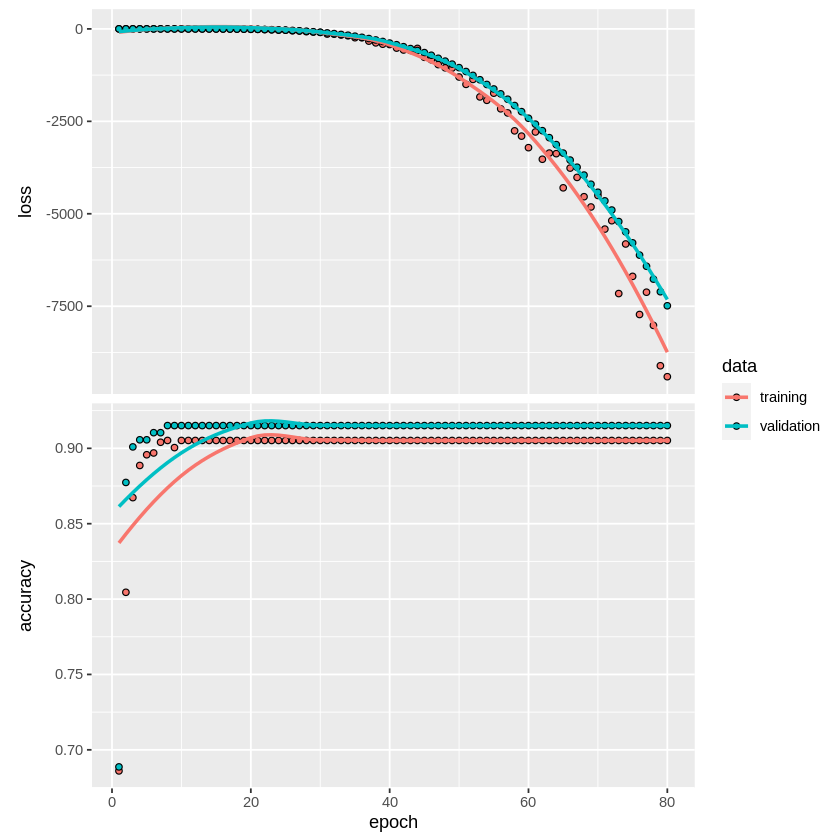

In [ ]:
# Can reproduce plot of metrics
plot(history)

In [ ]:
# Evaluate the model
model %>% evaluate(test_x, test_y, verbose = 0)
pred_probs <- predict(model, test_x)

library(Metrics)
auc(test_y, pred_probs)


loss      accuracy 
-9807.1210938     0.8920454

[1] 0.5

In [ ]:
table(test_y)

test_y
  1   2 
314  38 